In [2]:
import numpy as np

lst1 = range(5)
lst2 = range(2)

print(np.transpose([
    np.tile(lst1, len(lst2)),
    np.repeat(lst2, len(lst1))
]))

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]]


In [1]:
import pandas as pd
from tqdm import tqdm

path = "/gscratch/cse/lee0618/cifar-100/meta/pairs.csv"
df = pd.read_csv(path)

md_path = "/gscratch/cse/lee0618/cifar-100/meta/train.csv"
md = pd.read_csv(md_path)

print(len(df))
superclass_agreement = df.loc[df["superclass_1"] == df["superclass_2"]]
label_agreement = df.loc[df["label_1"] == df["label_2"]]
# for i in tqdm(range(len(df))):
#     assert md.loc[md["id"] == df.loc[i, "id_1"]].iloc[0]["group"] == 1
#     assert md.loc[md["id"] == df.loc[i, "id_2"]].iloc[0]["group"] == 2
print(len(superclass_agreement) / len(df))
print(len(label_agreement) / len(df))

70932
0.6718406361021824
0.5258698471775786


In [ ]:
import os
import sys
import torch

sys.path.insert(0, "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/models")
sys.path.insert(0, "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src")
from models.resnet_autoencoder import ResNet, get_configs

configs, bottleneck = get_configs()
model = ResNet(configs=configs, bottleneck=bottleneck, num_classes=100, pretrained=False)

x = torch.rand((2, 3, 224, 224))
model(x)

# CIFAR100 Unbalanced Groups Distribution

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_unbalanced_distribution(plot=False):
    np.random.seed(1)
    num_classes = 20
    # dist_first_half = np.random.uniform(low=0.1, high=0.5, size=num_classes//2)
    # dist_second_half = np.random.uniform(low=0.5, high=1.0, size=num_classes//2)
    dist_first_half = np.ones(num_classes//2) * 0.2
    dist_second_half = np.ones(num_classes//2) * 0.8
    dist = np.concatenate([dist_first_half, dist_second_half])
    if plot:
        fig = plt.figure(figsize=(30, 10))
        plt.bar(x=range(len(dist)), height=dist, color=["green" for i in range(10)] + ["blue" for i in range(10)])
    return dist / sum(dist)

# CIFAR100 pairs sample distribution

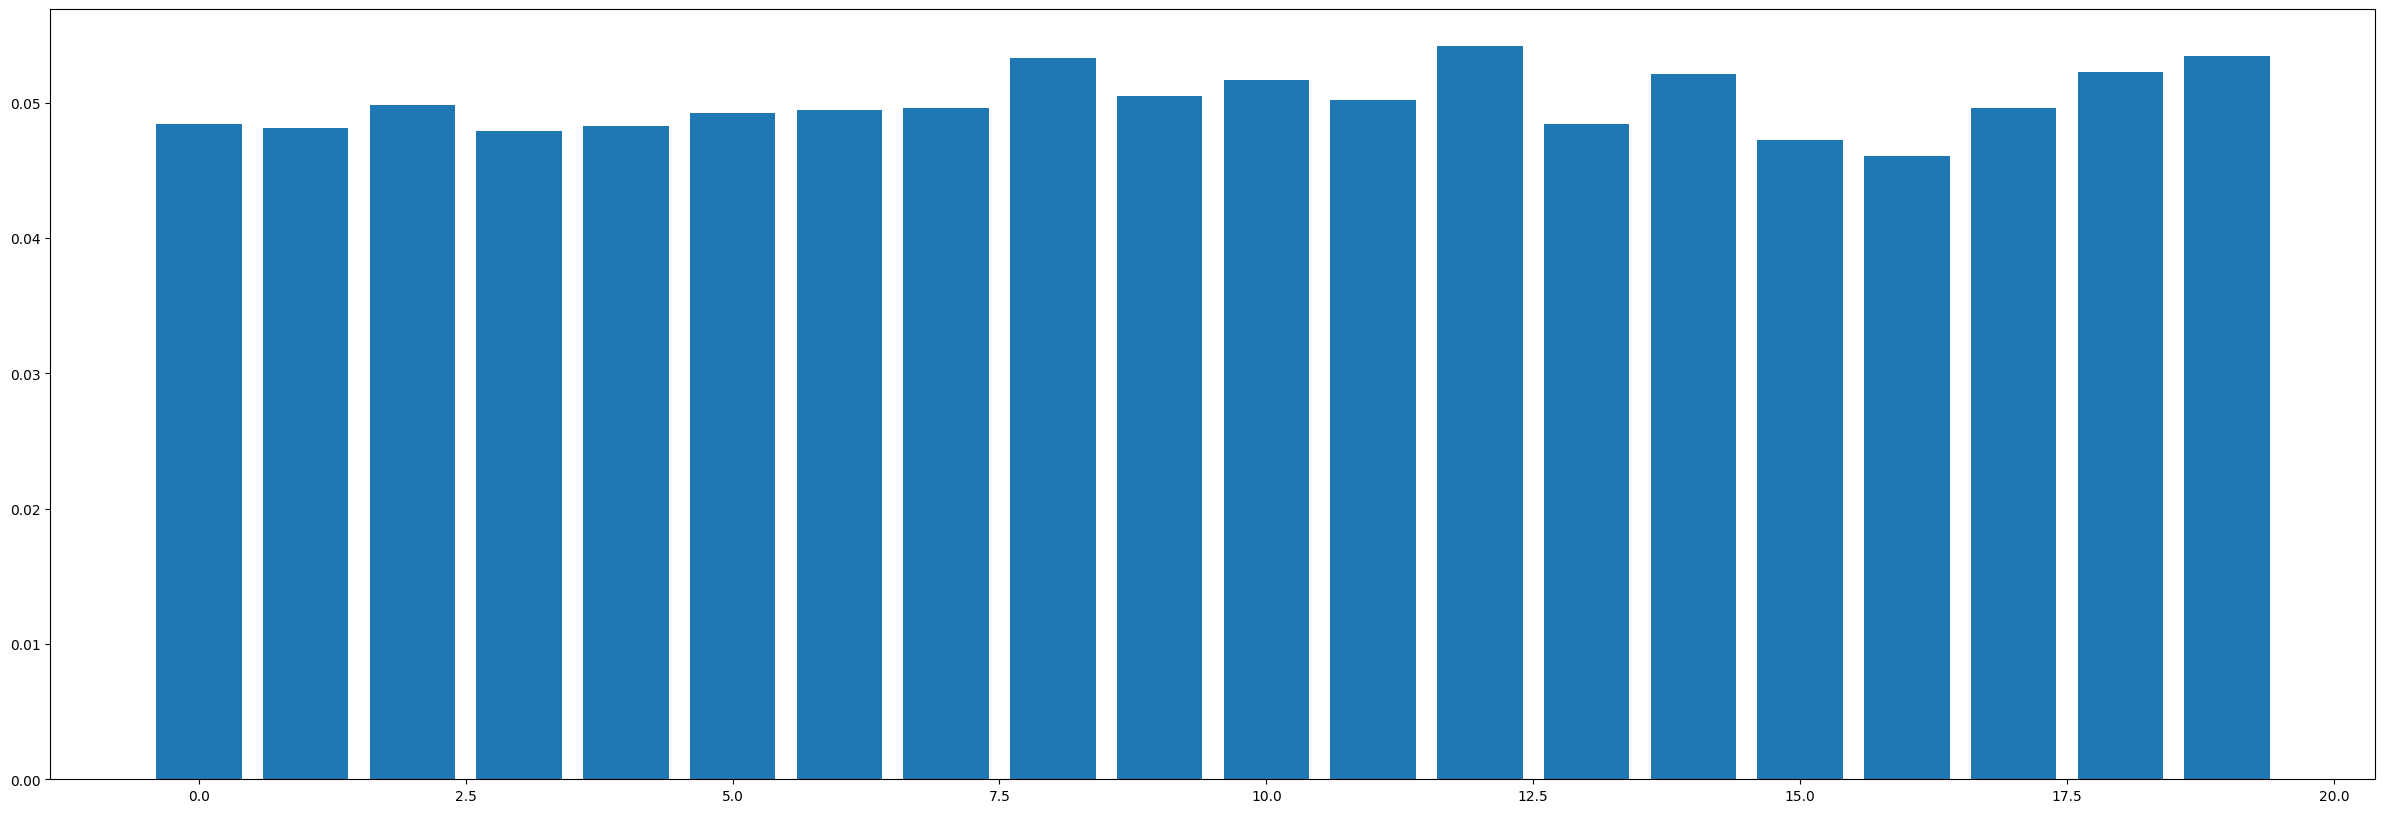

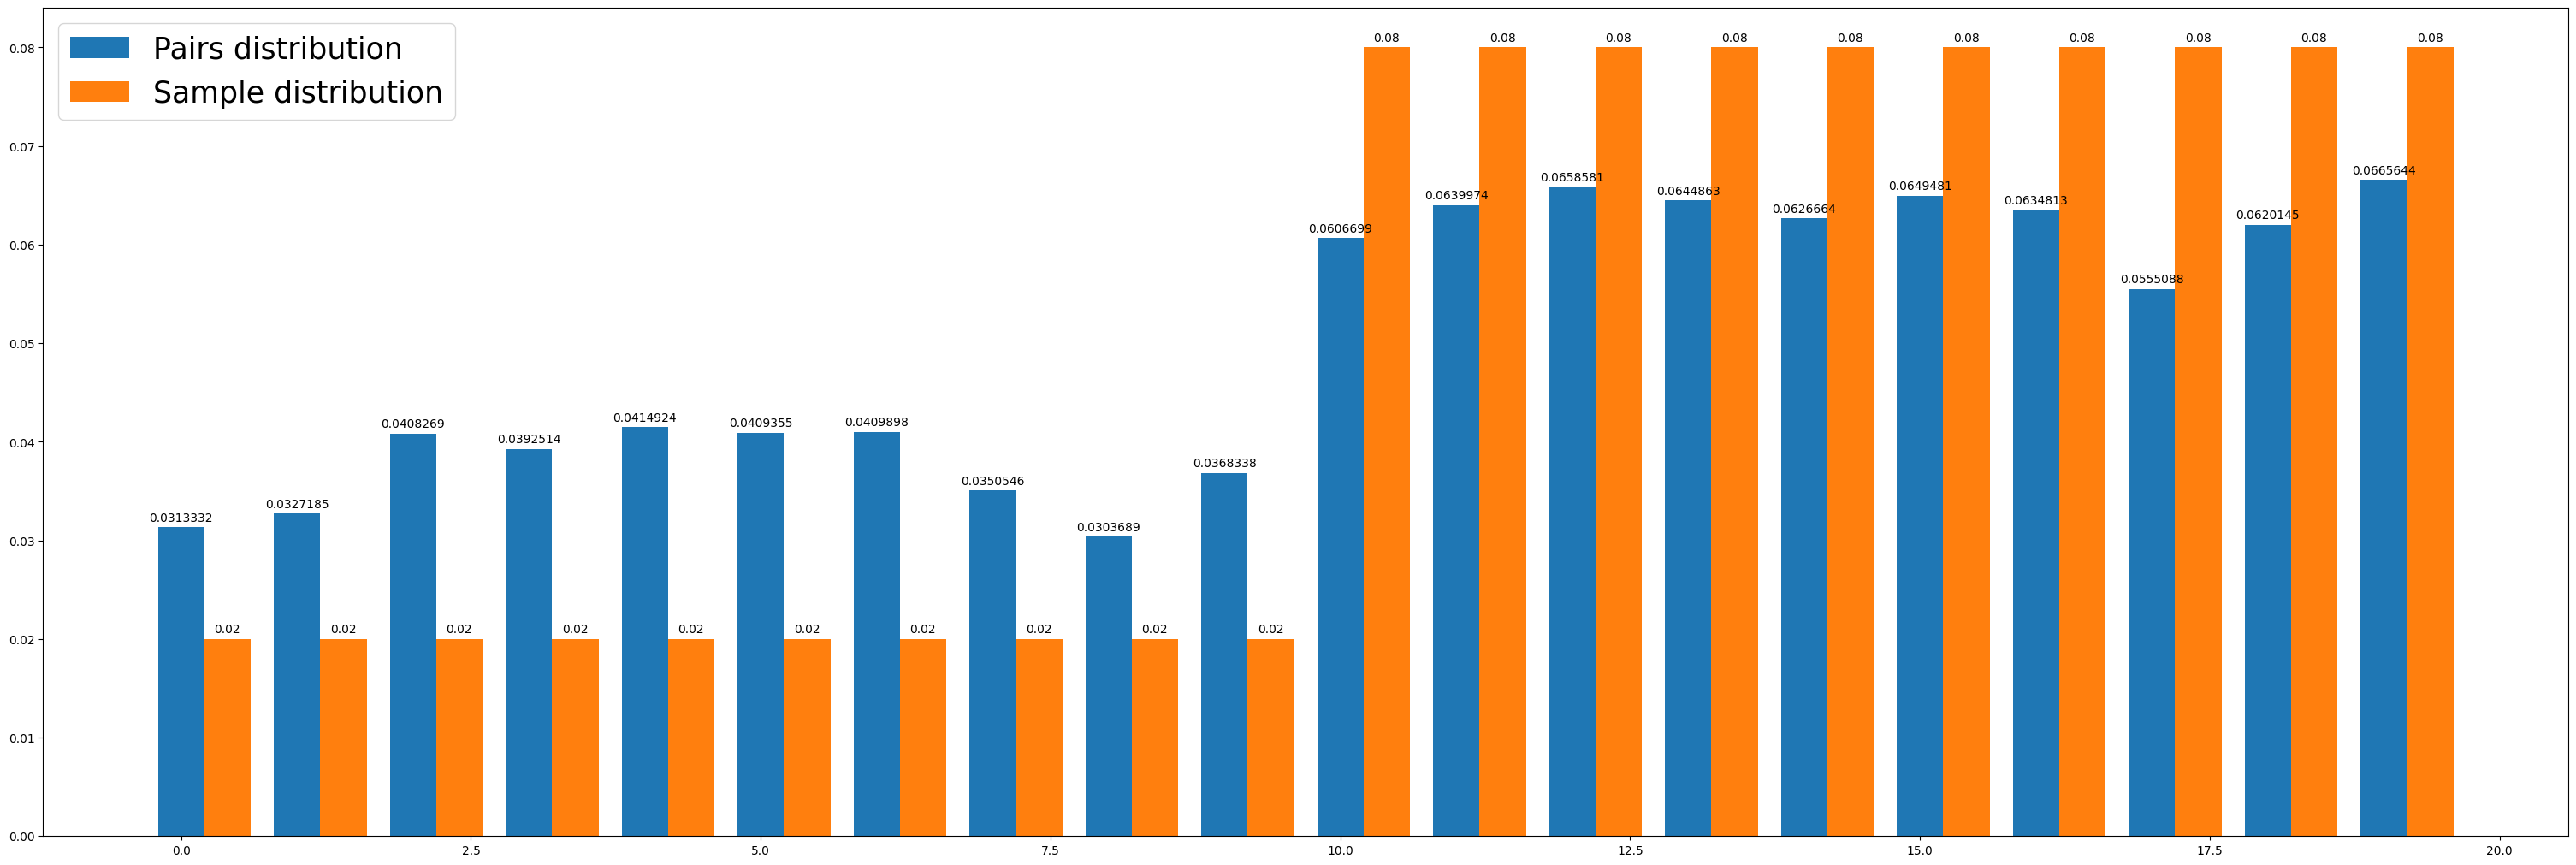

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pairs_path = "/gscratch/cse/lee0618/cifar-100/meta/pairs.csv"
unbalanced_pairs_path = "/gscratch/cse/lee0618/cifar-100/meta/unb_pairs.csv"

def get_pairs_sample_distribution(df, plot=False, sample="P"):
    group_cnt = np.zeros(20)
    for i in range(len(df)):
        group = int(df.loc[i, "superclass_1"])
        group_cnt[group] += 1
    group_dist = group_cnt / len(df)
    if plot:
        fig = plt.figure(figsize=(30, 10))
        plt.bar(x=range(20), height=group_dist)
    return group_dist

get_pairs_sample_distribution(pd.read_csv(pairs_path, index_col=0), plot=True)
unbalanced_pairs_dist = get_pairs_sample_distribution(pd.read_csv(unbalanced_pairs_path, index_col=0))
sample_dist = get_unbalanced_distribution()
width = 0.4
x = np.arange(20)
fig, ax = plt.subplots(layout="constrained", figsize=(30, 10))
rects = ax.bar(x=x, 
              height=unbalanced_pairs_dist, 
              width=width, 
              label="Pairs distribution")
ax.bar_label(rects, padding=3)
rects = ax.bar(x=x+width,
               height=sample_dist,
               width=width,
               label="Sample distribution")
ax.bar_label(rects, padding=3)
ax.legend(loc='upper left', prop={'size': 25})

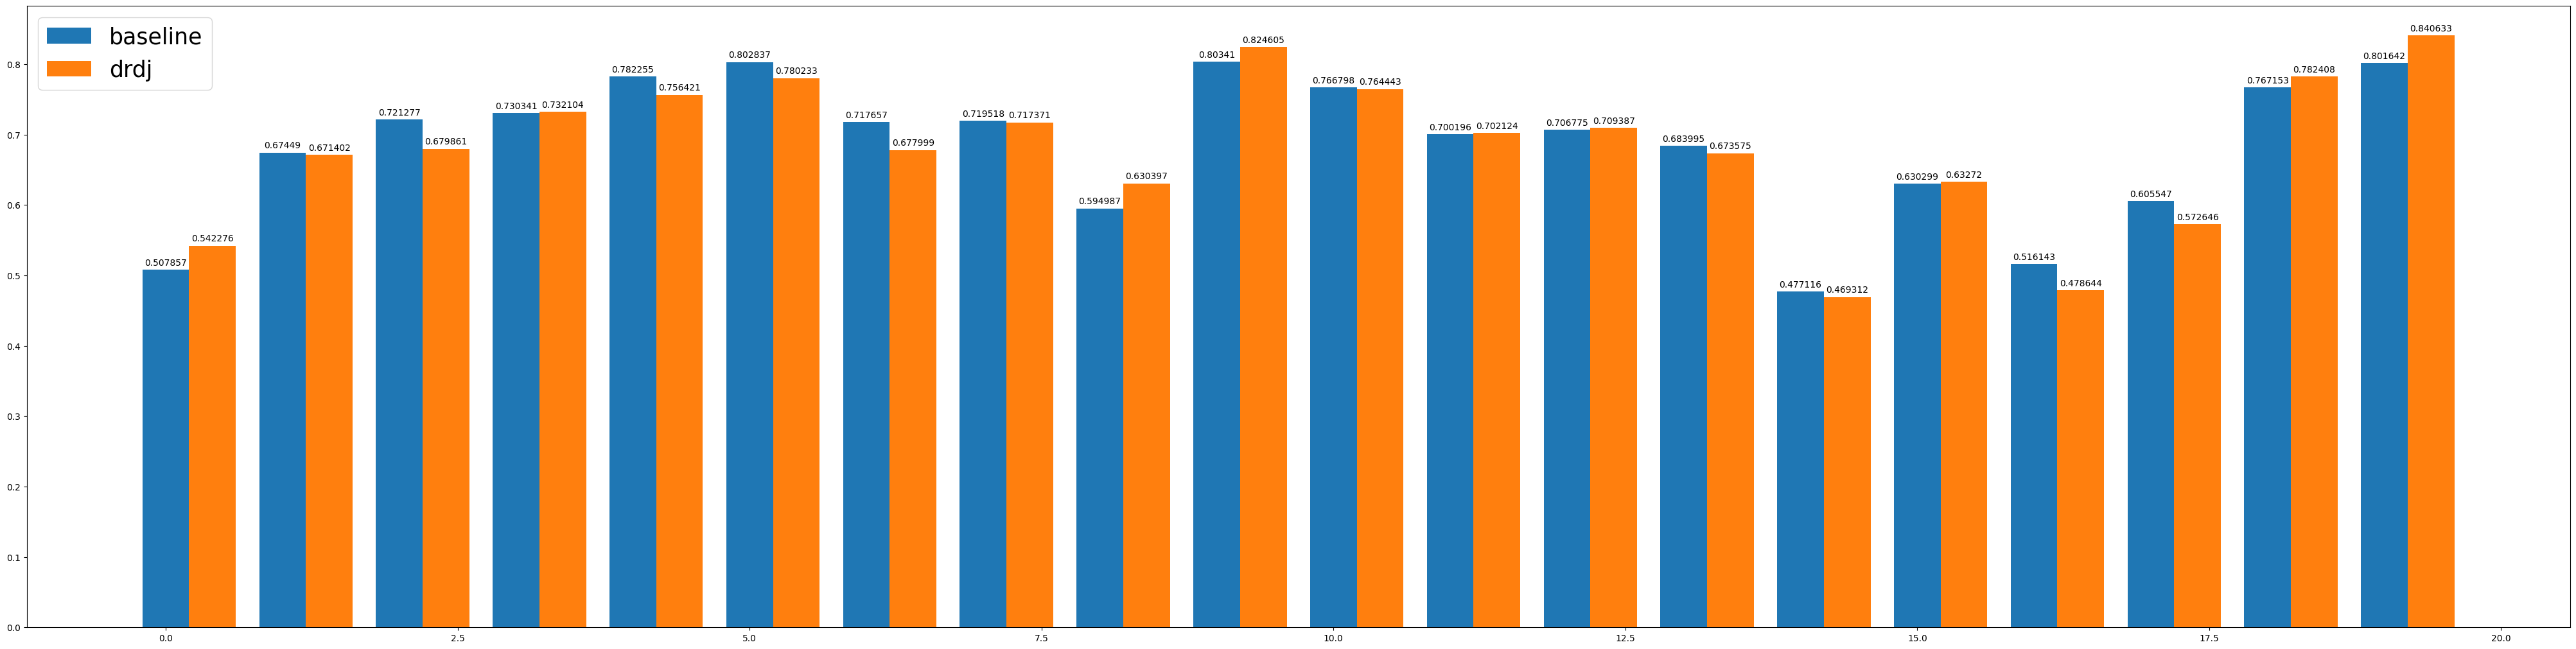

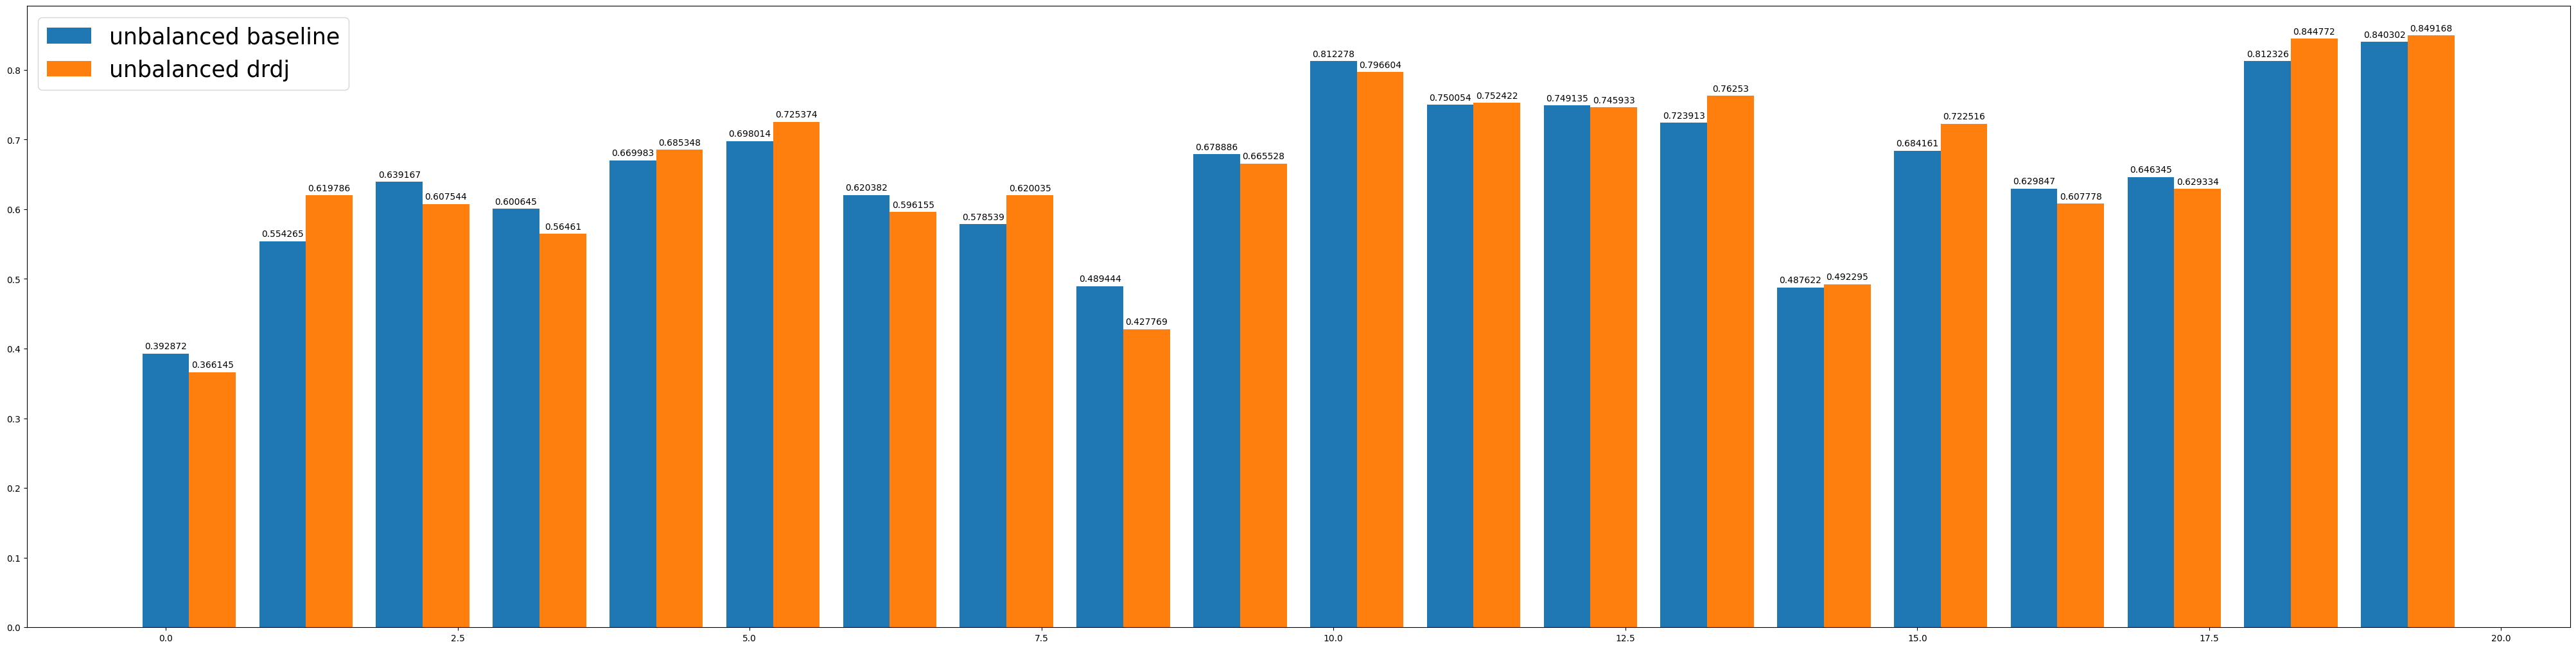

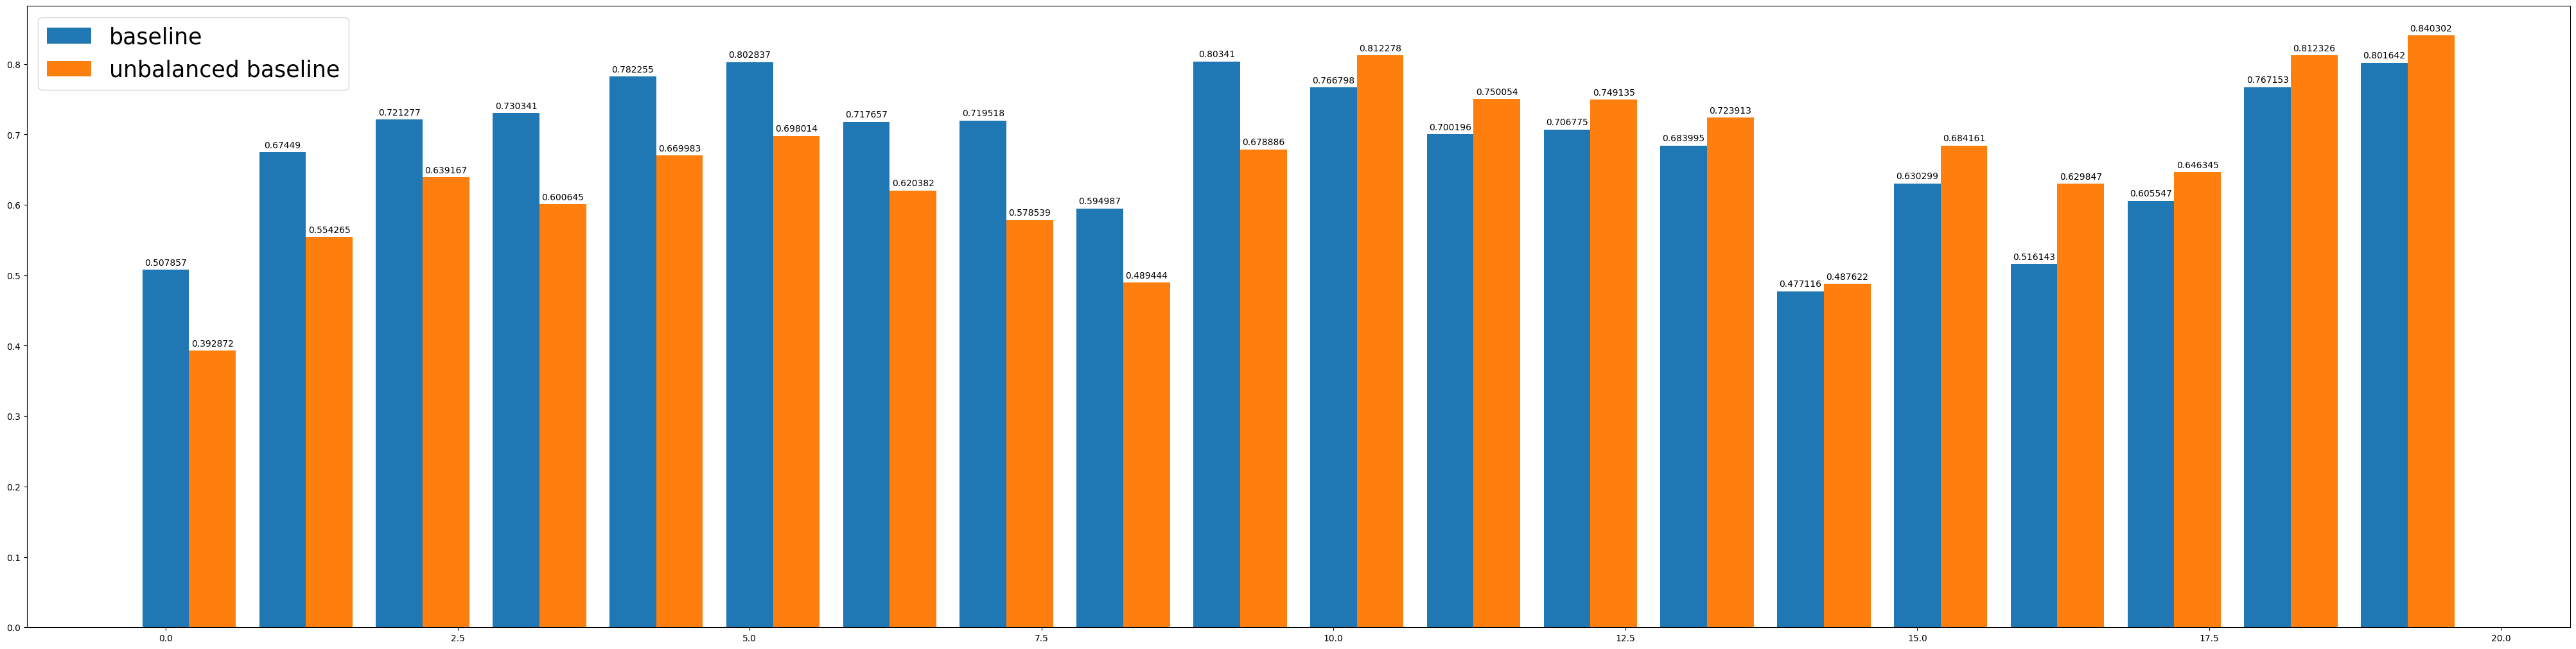

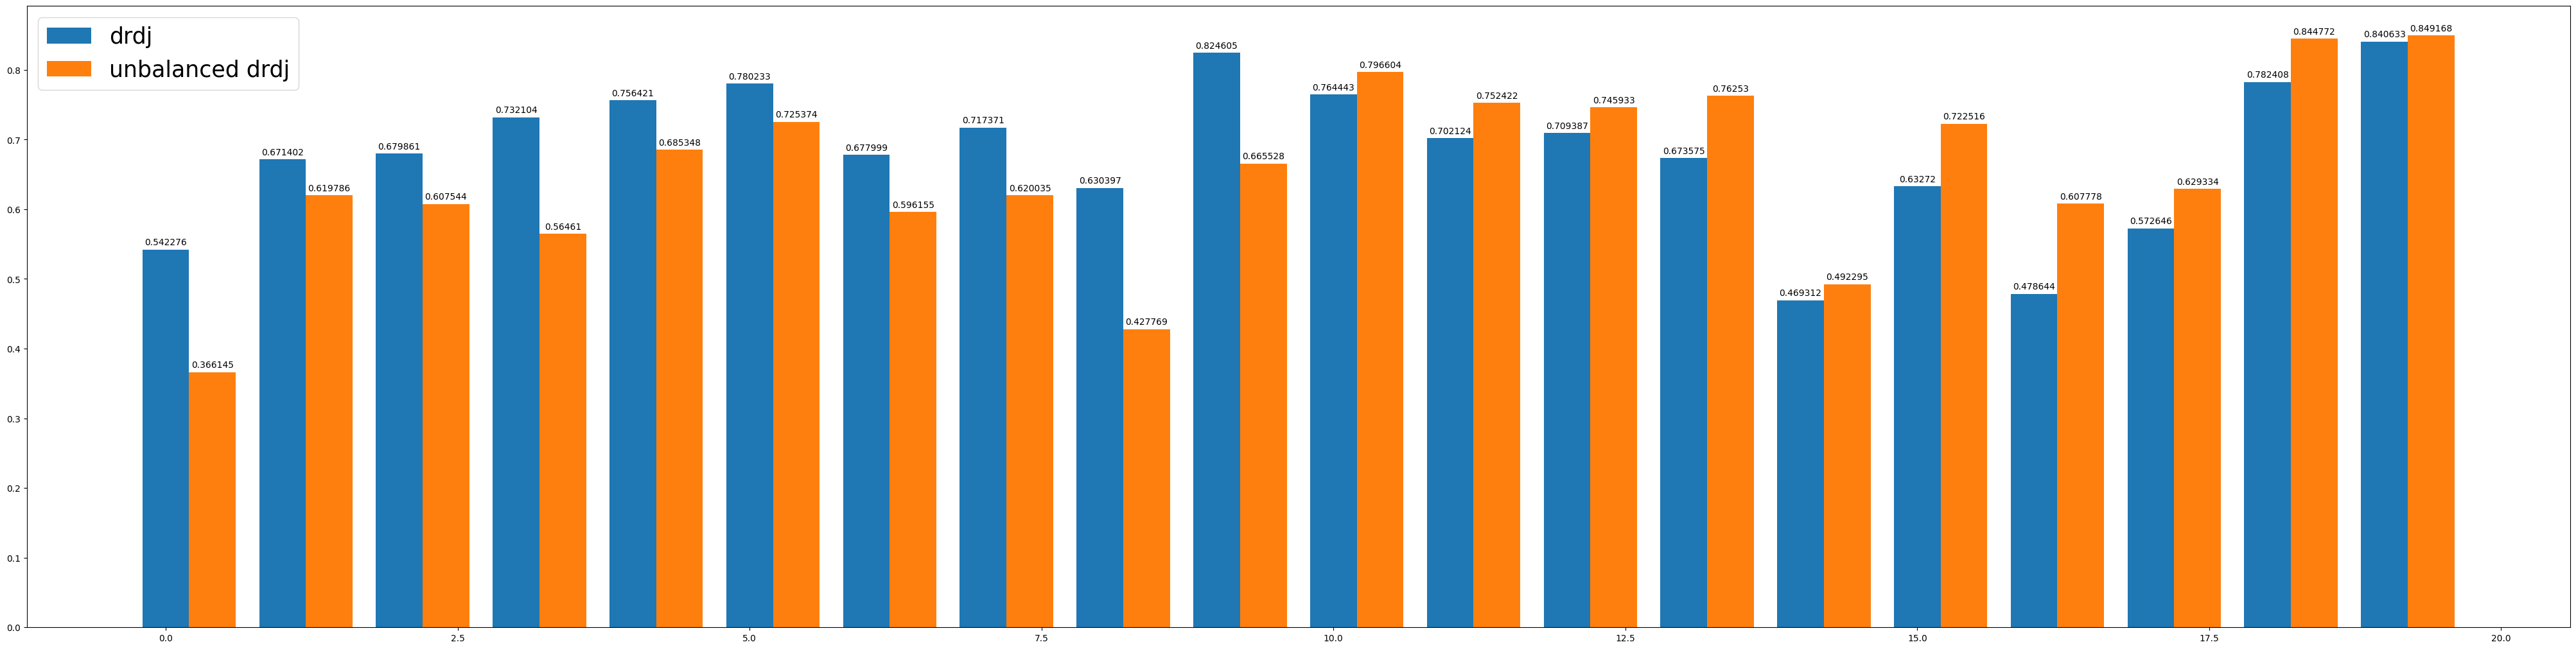

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

unb_baseline_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_resnet50_baseline_group_eval.csv"
baseline_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_resnet50_baseline_group_eval.csv"
unb_drdj_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_resnet50_drdj_vanilla_group_eval.csv"
drdj_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_resnet50_drdj_vanilla_group_eval.csv"

accs = []
width = 0.4
unb_baseline = pd.read_csv(unb_baseline_path, index_col=0)
baseline = pd.read_csv(baseline_path, index_col=0)
drdj = pd.read_csv(drdj_path, index_col=0)
unb_drdj = pd.read_csv(unb_drdj_path, index_col=0)

models = [baseline, drdj]
names = ["baseline", "drdj"]

def accuracy_bar_by_group(models, names):
    fig, ax = plt.subplots(layout="constrained", figsize=(40, 10))
    x = np.arange(20)
    patterns = ["", ""]
    for i, (name, model) in enumerate(zip(names, models)):
        rects = ax.bar(x=x + width * i, 
                    height=model.loc[1:, "accuracy"], 
                    width=width, 
                    label=name, 
                    hatch=[patterns[0] for i in range(10)] + [patterns[1] for i in range(10)])
        ax.bar_label(rects, padding=3)
    ax.legend(loc='upper left', prop={'size': 25})

accuracy_bar_by_group([baseline, drdj], ["baseline", "drdj"])
accuracy_bar_by_group([unb_baseline, unb_drdj], ["unbalanced baseline", "unbalanced drdj"])
accuracy_bar_by_group([baseline, unb_baseline], ["baseline", "unbalanced baseline"])
accuracy_bar_by_group([drdj, unb_drdj], ["drdj", "unbalanced drdj"])

In [7]:
# maximum drop down
def max_accuracy_drop(df):
    return df["accuracy"].max() - df["accuracy"].min()

# average drop down
def avg_accuracy_drop(baseline_df, compared_df):
    return (baseline_df["accuracy"] - compared_df["accuracy"])[:10].mean()

print(f"balanced baseline: {max_accuracy_drop(baseline)}")
print(f"unbalanced baseline: {max_accuracy_drop(unb_baseline)}")
print(f"balanced drdj: {max_accuracy_drop(drdj)}")
print(f"unbalanced drdj: {max_accuracy_drop(unb_drdj)}")

print(f"average accuracy drop baseline: {avg_accuracy_drop(baseline, unb_baseline)}")
print(f"average accuracy drop drdj: {avg_accuracy_drop(baseline, unb_drdj)}")

balanced baseline: 0.32629432758459676
unbalanced baseline: 0.4474304674077792
balanced drdj: 0.3713208093092991
unbalanced drdj: 0.48302355833256094
average accuracy drop baseline: 0.10411332551001806
average accuracy drop drdj: 0.10700655652013032


In [5]:
from wilds import get_dataset

root = "/gscratch/cse/lee0618/celebA"
dataset = get_dataset(dataset="celebA",
            download=False,
            root_dir=root)

In [3]:
import pandas as pd
import os

path = "/gscratch/cse/lee0618/celebA/celebA_v1.0/list_attr_celeba.csv"
root = "/gscratch/cse/lee0618/celebA/celebA_v1.0/img_align_celeba"
df = pd.read_csv(path)
for i in range(len(df)):
    image_id = df.iloc[i]["image_id"]
    image_path = os.path.join(root, image_id)
    if not os.path.exists(image_path):
        print(f"{image_id} doesn't exist")